In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from google.colab import drive
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import random
import time
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif,mutual_info_classif
from sklearn.preprocessing import Normalizer
from sklearn import model_selection
from sklearn import svm
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from enum import Enum

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')




[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_d

True

In [3]:
#import the data
drive.mount('/content/gdrive/', force_remount=True)

train_data_initial = pd.read_csv('/content/gdrive/MyDrive/ecse551-mp2/train.csv')
test_data = pd.read_csv('/content/gdrive/MyDrive/ecse551-mp2/test.csv')

print('shape train:',train_data_initial.shape)
print('shape test:',test_data.shape)


Mounted at /content/gdrive/
shape train: (718, 2)
shape test: (279, 2)


In [4]:
train_data_initial.columns.values.tolist()


['body', 'subreddit']

In [5]:
train_data_initial.describe()

,body,subreddit
count,718,718
unique,636,4
top,Hi there /u/LakotaPride! Welcome to /r/Trump. ...,Obama
freq,30,180


Obama    180
Trump    180
Ford     179
Musk     179
Name: subreddit, dtype: int64


Text(0.5, 0, 'subreddits')

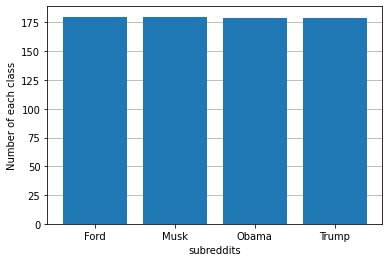

In [5]:
 #distribution of each subreddit
train_label_counts = train_data_initial["subreddit"].value_counts()
print(train_label_counts)
unique_labels = train_data_initial["subreddit"].unique()

fig, ax = plt.subplots()
ax.grid(zorder=1, axis="y")
ax.bar(unique_labels, train_label_counts, zorder=2)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(unique_labels)
ax.set_ylabel("Number of each class")
ax.set_xlabel("subreddits")

In [6]:
#check if tehre are any duplicates or isnull values,min and max
train_data_initial.duplicated().sum()
print("is duplicate:",train_data_initial.duplicated().sum())

print("is null:",train_data_initial.isnull().values.any())

print("maxmium values",train_data_initial.max(axis=0))
print("minimum values",train_data_initial.min(axis=0))

is duplicate: 82
is null: False
maxmium values body         you can collect free energy right now...with a...
subreddit                                                Trump
dtype: object
minimum values body         \nIf the link is behind a paywall, or for an a...
subreddit                                                 Ford
dtype: object


In [7]:
#describe the train data
train_data_initial['body'].apply(lambda x: len(x.split())).describe()

count    718.000000
mean     102.512535
std      104.806705
min        1.000000
25%       56.250000
50%       60.000000
75%       90.500000
max      557.000000
Name: body, dtype: float64

In [8]:
#describe the test data
test_data['body'].apply(lambda x: len(x.split())).describe()

count    279.000000
mean     103.426523
std      108.965248
min        1.000000
25%       59.000000
50%       60.000000
75%       87.000000
max      496.000000
Name: body, dtype: float64

In [6]:
def shuffle_data(df):
    random.seed(0)  # Use a fixed seed for the random number generator
    df = df.sample(frac=1, random_state=0).reset_index(drop=True) 
    return df

In [7]:
#shuffle the data and split the features from the label
train_data = shuffle_data(train_data_initial)

train_x = train_data["body"]
train_y = train_data["subreddit"]
test_x = test_data["body"]


In [11]:
print('train_data shape=>',train_data.shape)
print('train_data x=>',train_x.shape)
print('train_data y=>',train_y.shape)

train_data shape=> (718, 2)
train_data x=> (718,)
train_data y=> (718,)


In [12]:
print(train_y.head())

0    Obama
1    Trump
2     Musk
3     Ford
4    Obama
Name: subreddit, dtype: object


In [8]:
#stop words
sklearn_stop_words = text.ENGLISH_STOP_WORDS
print(len(sklearn_stop_words))
stop_words_nltk = set(stopwords.words('english'))
print(len(stop_words_nltk))

318
179


In [9]:
#prior class probability can either be learned or a uniform priority be used
prior_probabilities = Enum('prior_probabilities', ['learn', 'uniform'])


In [10]:
#function for creating the test csv file to upload to kaggle
def create_test_csv(data, outfile_name):
  rawdata= {'subreddit':data}
  csv = pd.DataFrame(rawdata, columns = ['subreddit'])
  csv.to_csv(outfile_name,index=True, header=True)
  print ("File saved.")

In [11]:
class CustomNaiveBayes:
    def __init__(self, alpha=0.01, prior=prior_probabilities.learn):
        self.alpha = alpha
        self.prior = prior

    #fit function
    def fit(self, X, y):
        X = X.toarray()
        class_counts = y.value_counts()

        num_labels = len(class_counts)

        #calculate prior probability
        if self.prior == prior_probabilities.learn:
          self.class_probabilities = class_counts / len(y)
        elif self.prior == prior_probabilities.uniform:
           self.class_probabilities = pd.Series(np.repeat(1/num_labels, num_labels), 
                                               index = class_counts.index)

        self.class_probabilities.sort_index(inplace=True)
        class_counts.sort_index(inplace=True)
        features_count = np.empty((num_labels, X.shape[1]))
        y_numpy = y.to_numpy()

        for i in range(num_labels):

            label = self.class_probabilities.index[i]
            X_this_label = X[np.nonzero(y_numpy == label), :]

            features_count[i,:] = np.sum(X_this_label, axis=1)

        # add Laplace smoothing
        smoothed_numerator = features_count + self.alpha
        smoothed_denominator = np.sum(smoothed_numerator,axis=1).reshape(-1,1)
        self.parameters = pd.DataFrame(smoothed_numerator / smoothed_denominator, index=self.class_probabilities.index)

    #predict function    
    def predict(self, X):

        X = X.toarray()
        delta = pd.DataFrame(columns=self.class_probabilities.index)
        for label in self.class_probabilities.index:

            class_probability = self.class_probabilities[label]
            theta_j_class = self.parameters.loc[label, :].to_numpy()
            prob_features_given_y = (theta_j_class ** X) * (1 - theta_j_class) ** (
                1 - X
            )
            prob_sample_given_y = np.prod(prob_features_given_y, axis=1)
            # Compute final probability
            term1 = np.log(class_probability)
            term2 = np.sum(X * np.log(theta_j_class), axis=1)
            term3 = np.sum((1 - X) * np.log(1 - theta_j_class), axis=1)
            delta_k = term1 + term2 + term3
            delta[label] = delta_k

        predicted_class = delta.idxmax(axis=1)
        return predicted_class.to_list()

    #score function
    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.count_nonzero(y == y_pred) / len(y_pred)
        return accuracy
       

    #get parameters function
    def get_params(self, deep=True):
        params = {"alpha": self.alpha,
                  "prior": self.prior}
        return params

    #set parameters function
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [12]:
#start testing different modes
#remove punctuation
import re
import string

data_x_punc = train_x.copy()

for i in range(data_x_punc.shape[0]):
  data_x_punc[i]= data_x_punc[i].translate(str.maketrans('', '', string.punctuation))



test_x_punc = test_x.copy()

for i in range(test_x_punc.shape[0]):
  test_x_punc[i]= test_x_punc[i].translate(str.maketrans('', '', string.punctuation))

In [20]:
print(data_x_punc.shape)
print(train_x.shape)
print(test_x_punc.shape)

(718,)
(718,)
(279,)


In [13]:
#create a dictionary of stop words
stop_words_nltk = set(stopwords.words('english'))
print(len(stop_words_nltk))
stop_words_sklearn = text.ENGLISH_STOP_WORDS
print(len(stop_words_sklearn))

stop_words_custom = [
    # All pronouns and associated words
    "i","i'll","i'd","i'm","i've","ive","me","myself","you",
    "you'll",
    "you'd",
    "you're",
    "you've",
    "yourself",
    "he",
    "he'll",
    "he'd",
    "he's",
    "him",
    "she",
    "she'll",
    "she'd",
    "she's",
    "her",
    "it",
    "it'll",
    "it'd",
    "it's",
    "itself",
    "oneself",
    "we",
    "we'll",
    "we'd",
    "we're",
    "we've",
    "us",
    "ourselves",
    "they",
    "they'll",
    "they'd",
    "they're",
    "they've",
    "them",
    "themselves",            
    "everyone",
    "everyone's",
    "everybody",
    "everybody's",
    "someone",
    "someone's",
    "somebody",
    "somebody's",
    "nobody",
    "nobody's",
    "anyone",
    "anyone's",
    "everything",
    "everything's",
    "something",
    "something's",
    "nothing",
    "nothing's",
    "anything",
    "anything's",
    # All determiners and associated words
    "a",
    "an",
    "the",
    "this",
    "that",
    "that's",
    "these",
    "those",
    "my",
    #"mine",   #Omitted since mine can refer to something else
    "your",
    "yours",
    "his",
    "hers",
    "its",
    "our",
    "ours",
    "own",
    "their",
    "theirs",
    "few",
    "much",
    "many",
    "lot",
    "lots",
    "some",
    "any",
    "enough",
    "all",
    "both",
    "half",
    "either",
    "neither",
    "each",
    "every",
    "certain",
    "other",
    "another",
    "such",
    "several",
    "multiple",
    # "what",    #Dealt with later on
    "rather",
    "quite",
    # All prepositions
    "aboard",
    "about",
    "above",
    "across",
    "after",
    "against",
    "along",
    "amid",
    "amidst",
    "among",
    "amongst",
    "anti",
    "around",
    "as",
    "at",
    "away",
    "before",
    "behind",
    "below",
    "beneath",
    "beside",
    "besides",
    "between",
    "beyond",
    "but",
    "by",
    "concerning",
    "considering",
    "despite",
    "down",
    "during",
    "except",
    "excepting",
    "excluding",
    "far",
    "following",
    "for",
    "from",
    "here",
    "here's",
    "in",
    "inside",
    "into",
    "left",
    "like",
    "minus",
    "near",
    "of",
    "off",
    "on",
    "onto",
    "opposite",
    "out",
    "outside",
    "over",
    "past",
    "per",
    "plus",
    "regarding",
    "right",
    #"round",   #Omitted
    #"save",    #Omitted
    "since",
    "than",
    "there",
    "there's",
    "through",
    "to",
    "toward",
    "towards",
    "under",
    "underneath",
    "unlike",
    "until",
    "up",
    "upon",
    "versus",
    "via",
    "with",
    "within",
    "without",
    # Irrelevant verbs
    "may",
    "might",
    "will",
    "won't",
    "would",
    "wouldn't",
    "can",
    "can't",
    "cannot",
    "could",
    "couldn't",
    "should",
    "shouldn't",
    "must",
    "must've",
    "be",
    "being",
    "been",
    "am",
    "are",
    "aren't",
    "ain't",
    "is",
    "isn't",
    "was",
    "wasn't",
    "were",
    "weren't",
    "do",
    "doing",
    "don't",
    "does",
    "doesn't",
    "did",
    "didn't",
    "done",
    "have",
    "haven't",
    "having",
    "has",
    "hasn't",
    "had",
    "hadn't",
    "get",
    "getting",
    "gets",
    "got",
    "gotten",
    "go",
    "going",
    "gonna",
    "goes",
    "went",
    "gone",
    "make",
    "making",
    "makes",
    "made",
    "take",
    "taking",
    "takes",
    "took",
    "taken",
    "need",
    "needing",
    "needs",
    "needed",
    "use",
    "using",
    "uses",
    "used",
    "want",
    "wanna",
    "wanting",
    "wants",
    "let",
    "lets",
    "letting",
    "let's",
    "suppose",
    "supposing",
    "supposes",
    "supposed",
    "seem",
    "seeming",
    "seems",
    "seemed",
    "say",
    "saying",
    "says",
    "said",
    "know",
    "knowing",
    "knows",
    "knew",
    "known",
    "look",
    "looking",
    "looked",
    "think",
    "thinking",
    "thinks",
    "thought",
    "feel",
    "feels",
    "felt",
    "based",
    "put",
    "puts",
    #"wanted"   #Omitted since the advective is relevant
    # Question words and associated words
    "who",
    "who's",
    "who've",
    "who'd",
    "whoever",
    "whoever's",
    "whom",
    "whomever",
    "whomever's",
    "whose",
    "whosever",
    "whosever's",
    "when",
    "whenever",
    "which",
    "whichever",
    "where",
    "where's",
    "where'd",
    "wherever",
    "why",
    "why's",
    "why'd",
    "whyever",
    "what",
    "what's",
    "whatever",
    "whence",
    "how",
    "how's",
    "how'd",
    "however",
    "whether",
    "whatsoever",
    # Connector words and irrelevant adverbs
    "and",
    "or",
    "not",
    "because",
    "also",
    "always",
    "never",
    "only",
    "really",
    "very",
    "greatly",
    "extremely",
    "somewhat",
    "no",
    "nope",
    "nah",
    "yes",
    "yep",
    "yeh",
    "yeah",
    "maybe",
    "perhaps",
    "more",
    "most",
    "less",
    "least",
    "good",
    "great",
    "well",
    "better",
    "best",
    "bad",
    "worse",
    "worst",
    "too",
    "thru",
    "though",
    "although",
    "yet",
    "already",
    "then",
    "even",
    "now",
    "sometimes",
    "still",
    "together",
    "altogether",
    "entirely",
    "fully",
    "entire",
    "whole",
    "completely",
    "utterly",
    "seemingly",
    "apparently",
    "clearly",
    "obviously",
    "actually",
    "actual",
    "usually",
    "usual",
    "literally",
    "honestly",
    "absolutely",
    "definitely",
    "generally",
    "totally",
    "finally",
    "basically",
    "essentially",
    "fundamentally",
    "automatically",
    "immediately",
    "necessarily",
    "primarily",
    "normally",
    "perfectly",
    "constantly",
    "particularly",
    "eventually",
    "hopefully",
    "mainly",
    "typically",
    "specifically",
    "differently",
    "appropriately",
    "plenty",
    "certainly",
    "unfortunately",
    "ultimately",
    "unlikely",
    "likely",
    "potentially",
    "fortunately",
    "personally",
    "directly",
    "indirectly",
    "nearly",
    "closely",
    "slightly",
    "probably",
    "possibly",
    "especially",
    "frequently",
    "often",
    "oftentimes",
    "seldom",
    "rarely",
    "sure",
    "while",
    "whilst",
    "able",
    "unable",
    "else",
    "ever",
    "once",
    "twice",
    "thrice",
    "almost",
    "again",
    "instead",
    "next",
    "previous",
    "unless",
    "somehow",
    "anyhow",
    "anywhere",
    "somewhere",
    "everywhere",
    "nowhere",
    "further",
    "anymore",
    "later",
    "ago",
    "ahead",
    "just",
    "same",
    "different",
    "big",
    "small",
    "little",
    "tiny",
    "large",
    "huge",
    "pretty",
    "mostly",
    "anyway",
    "anyways",
    "otherwise",
    "regardless",
    "throughout",
    "additionally",
    "moreover",
    "furthermore",
    "meanwhile",
    "afterwards",
    # Irrelevant nouns
    "thing",
    "thing's",
    "things",
    "stuff",
    "other's",
    "others",
    "another's",
    "total",
    "",
    "false",
    "none",
    "way",
    "kind",
    # Lettered numbers and order
    "zero",
    "zeros",
    "zeroes",
    "one",
    "ones",
    "two",
    "three",
    "four",
    "five",
    "six", 
    "seven",
    "eight",
    "nine",
    "ten",
    "twenty",
    "thirty",
    "forty",
    "fifty",
    "sixty",
    "seventy",
    "eighty",
    "ninety",
    "hundred",
    "hundreds",
    "thousand",
    "thousands",
    "million",
    "millions",
    "first",
    "last",
    "second",
    "third",
    "fourth",
    "fifth",
    "sixth",
    "seventh",
    "eigth",
    "ninth",
    "tenth",
    "firstly",
    "secondly",
    "thirdly",
    "lastly",
    # Greetings and slang
    "hello",
    "hi",
    "hey",
    "sup",
    "yo",
    "greetings",
    "please",
    "okay",
    "ok",
    "y'all",
    "lol",
    "rofl",
    "thank",
    "thanks",
    "alright",
    "kinda",
    "dont",
    "sorry",
    "idk",
    "tldr",
    "tl",
    "dr",  #This means that dr (doctor) is a bad feature because of tl;dr
    "tbh",
    "dude",
    "tho",
    "aka",
    "plz",
    "pls",
    "bit",
    "don",
    # Miscellaneous
    "www",
    "https",
    "http",
    "com",
    "etc",
    "html",
    "reddit",
    "subreddit",
    "subreddits",
    "comments",
    "reply",
    "replies",
    "thread",
    "threads",
    "post",
    "posts",
    "website",
    "websites",
    "web site",
    "web sites"]
print('length custom:',len(stop_words_custom))



179
318
length custom: 590


In [14]:
#remove punctuation from custom stop words
stop_words_custom_punc = stop_words_custom
print(len(stop_words_custom_punc))
for i in range(len(stop_words_custom_punc)):
 stop_words_custom_punc[i]= stop_words_custom_punc[i].translate(str.maketrans('', '', string.punctuation))

590


In [15]:
#lemmatization 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

class LemmaTokenizer_Pos:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos =get_wordnet_pos(t)) for t in word_tokenize(doc) if t.isalpha()]

class LemmaTokenizer:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos ="v") for t in word_tokenize(doc) if t.isalpha()]

class LemmaTokenizer_word:
     def __init__(self):
       self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
       return [self.wnl.lemmatize(t,pos ="v") for t in word_tokenize(doc) ]


class StemTokenizer:
     def __init__(self):
       self.wnl =PorterStemmer()
     def __call__(self, doc):
       return [self.wnl.stem(t) for t in word_tokenize(doc) if t.isalpha()]


In [25]:
#start testing different modes
#select alpha

t_start = time.time()

pipe_params = {
    "selecter__k":[5000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5],
    "vect__stop_words": [stop_words_custom_punc],
}

vectorizer = CountVectorizer()
selecter = SelectKBest(chi2)
normalizer = Normalizer()
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("norm", normalizer), ("selecter", selecter), ("classify", CustomNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()


print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best accuracy is 0.9303321678321679.
The winning parameters are {'classify__alpha': 0.02, 'selecter__k': 5000, 'vect__stop_words': ['i', 'ill', 'id', 'im', 'ive', 'ive', 'me', 'myself', 'you', 'youll', 'youd', 'youre', 'youve', 'yourself', 'he', 'hell', 'hed', 'hes', 'him', 'she', 'shell', 'shed', 'shes', 'her', 'it', 'itll', 'itd', 'its', 'itself', 'oneself', 'we', 'well', 'wed', 'were', 'weve', 'us', 'ourselves', 'they', 'theyll', 'theyd', 'theyre', 'theyve', 'them', 'themselves', 'everyone', 'everyones', 'everybody', 'everybodys', 'someone', 'someones', 'somebody', 'somebodys', 'nobody', 'nobodys', 'anyone', 'anyones', 'everything', 'everythings', 'something', 'somethings', 'nothing', 'nothings', 'anything', 'anythings', 'a', 'an', 'the', 'this', 'that', 'thats', 'these', 'those', 'my', 'your', 'yours', 'his', 'hers', 'its', 'our', 'ours', 'own', 'their', 'theirs', 'few', 'much', 'many', 'lot', 'lots', 'some', 'any', 'e

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['site', 'sites', 'web'] not in stop_words.
  warnings.warn(


In [26]:
#start testing different modes
#remove normalize 
pipe_params = {
    "selecter__k":[5000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer()
selecter = SelectKBest(chi2)
normalizer = Normalizer()
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("norm", normalizer), ("selecter", selecter), ("classify", CustomNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best accuracy is 0.8996697746697746.
The winning parameters are {'classify__alpha': 0.001, 'selecter__k': 5000}


In [27]:
#start testing different modes
#stop words - scikitlearn
t_start = time.time()

pipe_params = {
    "selecter__k":[5000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer(stop_words=list(stop_words_sklearn))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter), ("classify", CustomNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best accuracy is 0.9178321678321678.
The winning parameters are {'classify__alpha': 0.1, 'selecter__k': 5000}
Run time:  6.200 seconds


In [29]:
#stop words - nltk
t_start = time.time()

pipe_params = {
    "selecter__k":[5000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer(stop_words=list(stop_words_nltk))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter), ("classify", CustomNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best accuracy is 0.910878010878011.
The winning parameters are {'classify__alpha': 0.01, 'selecter__k': 5000}
Run time:  4.087 seconds


In [27]:
#stop words - custom
pipe_params = {
    "selecter__k":[5000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

t_start = time.time()

vectorizer = CountVectorizer(stop_words=list(stop_words_custom_punc))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter), ("classify", CustomNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best accuracy is 0.9359168609168609.
The winning parameters are {'classify__alpha': 0.5, 'selecter__k': 5000}
Run time:  3.791 seconds


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['site', 'sites', 'web'] not in stop_words.
  warnings.warn(


In [31]:
stop_words_library = stop_words_sklearn.union(stop_words_nltk)
final_stop_words =  set(stop_words_custom) | stop_words_library

In [28]:
#create new stop word dictionary
stop_words_library = stop_words_sklearn.union(stop_words_nltk)
final_stop_words =  set(stop_words_custom_punc) | stop_words_library
t_start = time.time()


pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer(stop_words=list(final_stop_words))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter), ("classify", CustomNaiveBayes())]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best accuracy is 0.9429001554001555.
The winning parameters are {'classify__alpha': 0.5, 'selecter__k': 5000}
Run time:  7.653 seconds


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['site', 'sites', 'web'] not in stop_words.
  warnings.warn(


In [29]:
#generate test.csv
y_pred = grid.predict(test_x)

create_test_csv(y_pred,"customNaiveBayes_12032023_02.csv")

File saved.


In [34]:
#final stop words - test normalize
t_start = time.time()

pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer(stop_words=list(final_stop_words))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()


print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best accuracy is 0.9429001554001555.
The winning parameters are {'classify__alpha': 0.5, 'selecter__k': 5000}
Run time:  9.414 seconds


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['site', 'sites', 'web'] not in stop_words.
  warnings.warn(


In [36]:
#test lemmatizer- LemmaTokenizer_Pos

t_start = time.time()

pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer(stop_words=list(final_stop_words),tokenizer=LemmaTokenizer())
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.9/dist-packages/

The best accuracy is 0.9192016317016318.
The winning parameters are {'classify__alpha': 0.1, 'selecter__k': 3000}
Run time:  43.618 seconds


In [37]:
#test lemmatizer- LemmaTokenizer_word

t_start = time.time()

pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = CountVectorizer(stop_words=list(final_stop_words),tokenizer=LemmaTokenizer_word())
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'base', 'bite', 'comment', 'concern', 'consider', 'exclude', 'follow', 'gon', 'greet', 'leave', "n't", 'na', 'regard', 'sha', 'sit', 'site', 'wan', 'web', 'win', 'wo'] not in stop_words.
  warnings.warn(


The best accuracy is 0.8983100233100233.
The winning parameters are {'classify__alpha': 0.01, 'selecter__k': 5000}
Run time:  50.826 seconds


In [38]:
#test stemmizer- StemTokenizer

t_start = time.time()

pipe_params = {
    
}
vectorizer = CountVectorizer()
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=30)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best accuracy is 0.72004662004662.
The winning parameters are {}
Run time:  6.797 seconds


In [ ]:
#test stemmizer and lemmatizer

t_start = time.time()

pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5],
    "countVectorizer__tokenizer": [StemTokenizer(), LemmaTokenizer_word()]
}

vectorizer = CountVectorizer(stop_words=list(final_stop_words))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=1000)

grid.fit(train_x,train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



In [20]:
#test tfidf-without lemmarizer
import time

t_start = time.time()

pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = TfidfVectorizer(stop_words=list(final_stop_words))
selecter = SelectKBest(chi2)
model = CustomNaiveBayes()

pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best accuracy is 0.9177641802641803.
The winning parameters are {'classify__alpha': 0.01, 'selecter__k': 5000}
Run time:  12.622 seconds


In [21]:
#test tfidf-without lemmarizer-with normalize
import time

t_start = time.time()

pipe_params = {
    "selecter__k":[5000,3000],
    "classify__alpha" : [0.001, 0.01, 0.1,0.02,0.5]
}

vectorizer = TfidfVectorizer(stop_words=list(final_stop_words))
selecter = SelectKBest(chi2)
normalizer = Normalizer()
model = CustomNaiveBayes()


pipe = Pipeline(
    [("vect", vectorizer), ("selecter", selecter), ("norm", normalizer) ,("classify", model)]
)

grid = model_selection.GridSearchCV(pipe, pipe_params, verbose=1, n_jobs=-1)

grid.fit(train_x, train_y)

t_end = time.time()

print(f"The best accuracy is {grid.best_score_}.")
print(f"The winning parameters are {grid.best_params_}")
print(f"Run time: {t_end-t_start: .3f} seconds")



Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best accuracy is 0.9177738927738928.
The winning parameters are {'classify__alpha': 0.1, 'selecter__k': 5000}
Run time:  16.289 seconds


In [22]:
def print_best_params(grid):
  bestParameters = grid.best_estimator_.get_params()
  # print(bestParameters)
  for paramName in sorted(bestParameters.keys()):
    print("\t%s: %r" % (paramName, bestParameters[paramName]))